<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/descriptive_analytics/motifs/motifs_aapl_15min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Motif Analysis for Apple Stock**

In this notebook we will search for motifs in the Apple training data

## Install libraries

In [1]:
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 2.1 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=d2f72c6440a7040afad72ce0b2c20e8a684dfd621db03dda832f63a791514e66
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [2]:
!pip install stumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 136 kB 2.0 MB/s 


In [3]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 2.1 MB/s 


## Base Library Import

In [4]:
import os
import re
from glob import glob
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

## Get The data

We will only work with AAPL data in this notebook

In [5]:
get_name = lambda x : re.search('\w+(?=_15min)', x).group()

In [6]:
!git clone https://github.com/itberrios/algotrading

Cloning into 'algotrading'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 160 (delta 44), reused 87 (delta 8), pack-reused 0
Receiving objects: 100% (160/160), 26.33 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [7]:
df = pd.read_csv(r'algotrading/data/clean/AAPL_15min_clean.csv', index_col=0)
df.shape

(13267, 5)

In [8]:
# get roughly 14 months of training data
train_df = df.iloc[:8000, :]

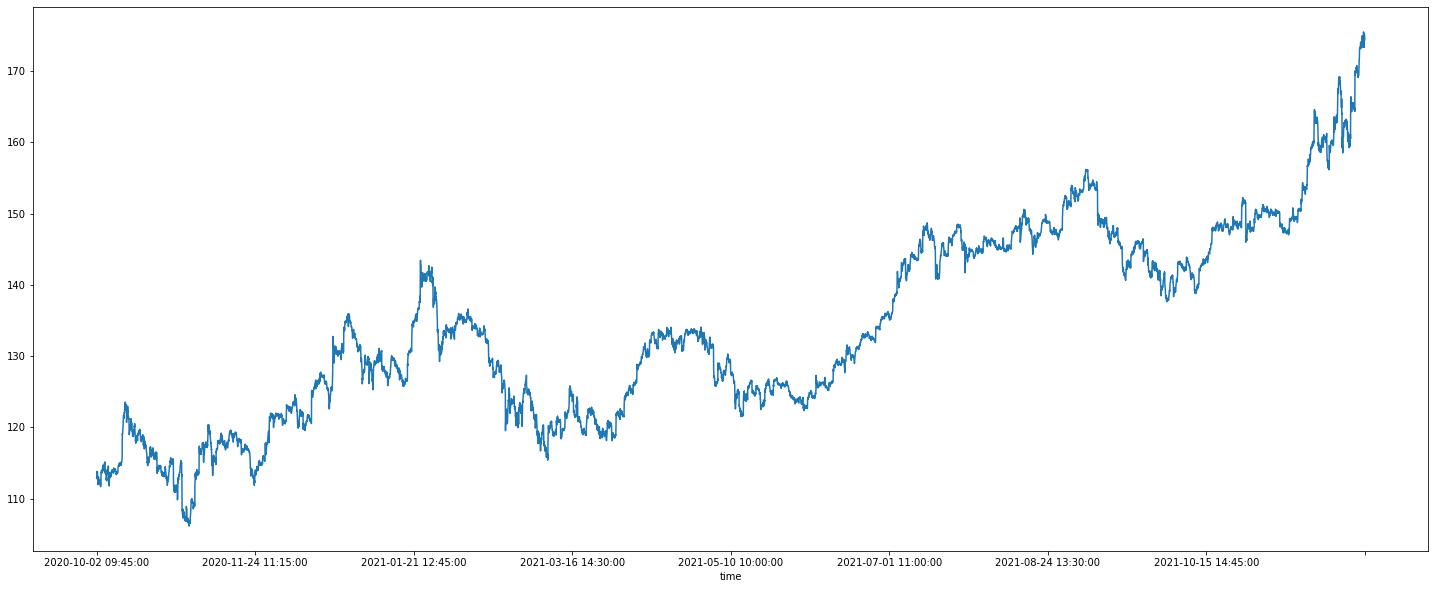

In [9]:
train_df['close'].plot(figsize=(25, 10));

## **Perform Motif Search**

For the Motif Search, we will use [STUMPY](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) which is a powerful library that can efficiently search through large datasets.

For the initial search, we will make the hypothesis that Motifs or similar events may occur over a period of 4 hours, while sampling at a 15min interval. This means that we will use 16 time samples for our window_4hr size

In [10]:
import stumpy

window_4hr = 16 
matrix_profile_4hr = stumpy.stump(train_df['close'].sort_index(), m=window_4hr)

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


Collect the dominant motifs that were discovered. We will try to collect a lot of them so we can cluster them later. Note that we will remove closely spaced motifs to we don't get a false sense of pattern formation. i.e. motifs within +/-5 will usually have strong matches even if they do not form any kind of unique pattern.

NOTE: We also need to clean motifs that do not take place over a continuous run, i.e. a motif that begins on one day and ends on the next day, these need to be removed.

In [39]:
def filter_motif_indexes(matrix_profile, thresh):
    ''' Removes motif indexes that fall withing the threshold distance 
        from eachother
        Inputs:
            matrix_profile (array) matrix profile output from stump()
            thresh (int) - threshold for similar motifs spaced in time 
        Outputs:    
            usefule_motif_indexes (list) filtered motif indexes
        '''
    # store motif indexes to ensure that matches close in time are not plotted
    motif_indexes = []
    useful_motif_indexes = []

    i = 0
    while i < matrix_profile.shape[0]:
        # get motifs
        motif_idx = np.argsort(matrix_profile[:, 0])[i]
        nearest_neighbor_idx = matrix_profile[motif_idx, 1]

        if i == 0:
            useful_motif_indexes.append(motif_idx)

            # store motif index
            motif_indexes.append(motif_idx)

            # increment i
            i += 1

            continue
        
        # only store motifs with adequate spacing
        if (np.min(np.abs(motif_idx - np.array(motif_indexes))) > thresh):
            useful_motif_indexes.append(motif_idx)

        # store motif index
        motif_indexes.append(motif_idx)
        
        # increment i
        i += 1

    return useful_motif_indexes

In [13]:
useful_motif_indexes_4hr = filter_motif_indexes(matrix_profile_4hr, thresh=12)

In [15]:
len(useful_motif_indexes_4hr)

276

We will now gather the clean motifs that do not have instances that fall outside of a single trading day. We will use 3 15min samples to see how the stock price behaves before and after the motif. Since the extended motif is more likely to fall outside of the day window_4hr, we will use a flag to indicate whether it does or not.

In [22]:
def clean_motifs(useful_motif_indexes, matrix_profile, window, ext_window):
    ''' Removes motifs that fall outside of the 1 day trading window. If a motif
        falls outside the 1 day regular trading hours, than it will have false
        implications of rising or falling prices.
        Inputs:
            useful_motif_indexes (list) motif indexes where closly spaced motifs
                                        have been removed
            matrix_profile (array) matrix_profile output of stump()
            window (int) window used to obtain motifs
            ext_window (int) window for external motif look ahead/behind
        Outputs:
            motifs (array) - cleaned motifs (spaced apart and do not overlap days)
            motif_idxs (array) - start DateTime indexes for each motif
            ext_motifs (array) - extended motifs (spaced apart, may overlap days)
            ext_outside (array) indicates whether an extended motif overlaps a day
        '''
    motifs = []
    motif_idxs = []
    ext_motifs = []
    ext_outside = [] # indicates if extended motif is outside of the day window

    # motif extension window_4hr
    ext_wind = 3

    for motif_idx in useful_motif_indexes:
        nearest_neighbor_idx = matrix_profile[motif_idx, 1]
        motif = train_df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + window]
        ext_motif = train_df['close'].iloc[nearest_neighbor_idx - ext_window:nearest_neighbor_idx + window + ext_window]

        # only include motifs that take place over the course of multiple days
        if len(pd.to_datetime(motif.index).dayofweek.unique()) == 1:
            motifs.append(motif.to_numpy())
            motif_idxs.append(nearest_neighbor_idx) # start index of motif
            ext_motifs.append(ext_motif.to_numpy())

            # get flag to determine if extended motif fall outside of the day window_4hr
            if len(pd.to_datetime(ext_motif.index).dayofweek.unique()) == 1:
                ext_outside.append(0)
            else:
                ext_outside.append(1)

    motifs = np.array(motifs)
    motif_idxs = np.array(motif_idxs)
    ext_motifs = np.array(ext_motifs)
    ext_outside = np.array(ext_outside)

    return motifs, motif_idxs, ext_motifs, ext_outside

In [23]:
ext_window = 3
motifs, motif_idxs, ext_motifs, ext_outside = clean_motifs(useful_motif_indexes_4hr, 
                                                           matrix_profile_4hr, 
                                                           window_4hr, 
                                                           ext_window)

## Plot Top 25 Motifs

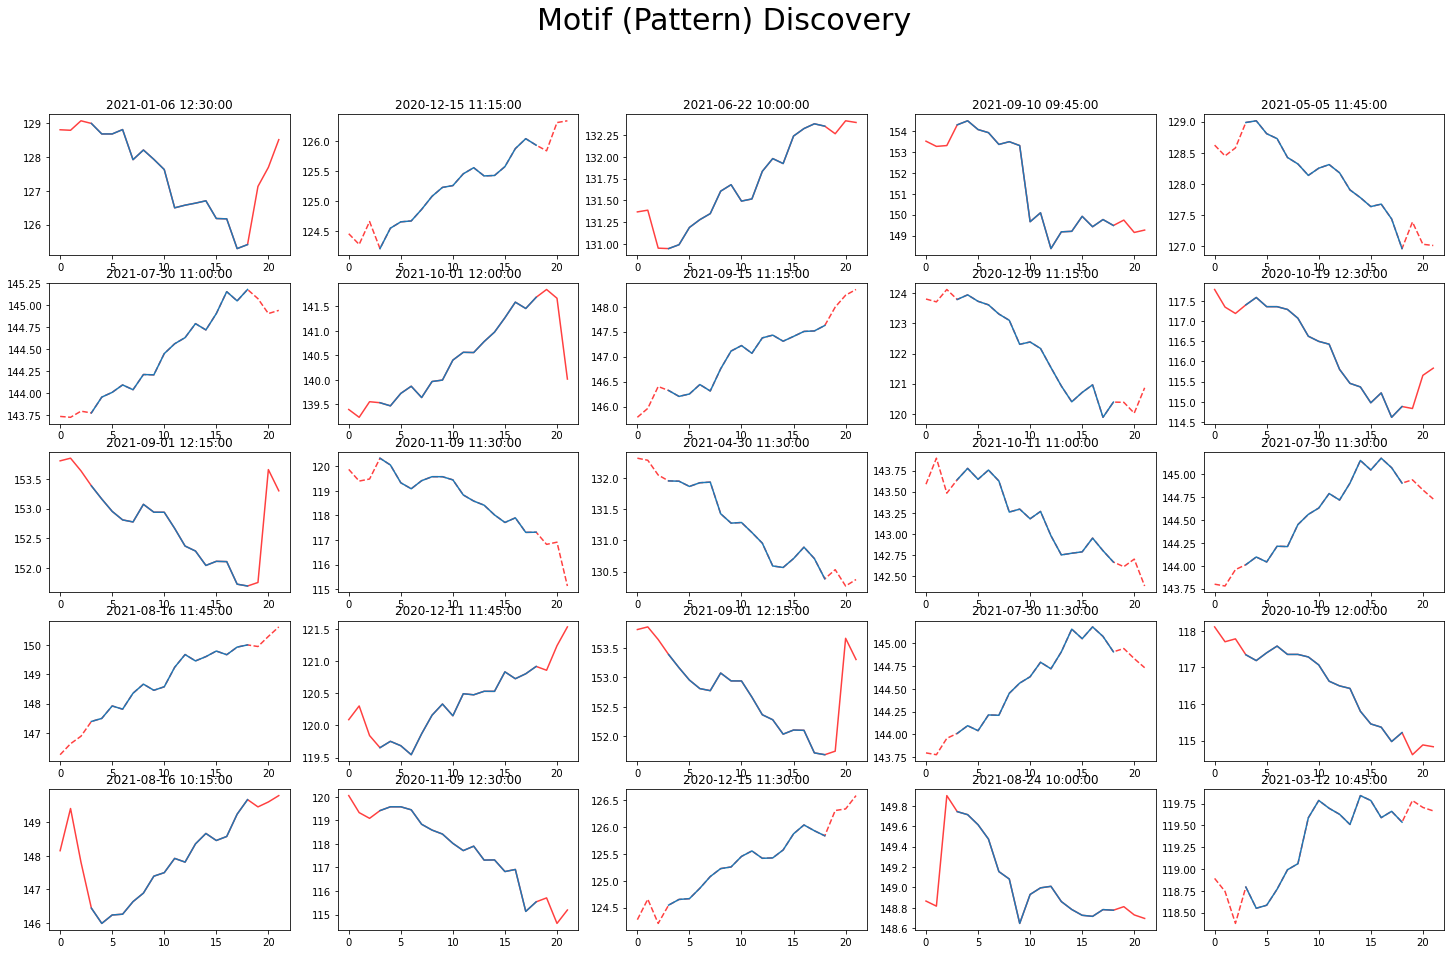

In [26]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []

fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif = motifs[i]
    m_idx = motif_idxs[i]
    ext_motif = ext_motifs[i]
    ext_out = ext_outside[i]


    # plot motif 
    if ext_out == 0:
        plt.plot(ext_motif, 'r--', alpha=0.75)
        plt.plot(np.arange(ext_window, window_4hr + ext_window), motif)
    else:
        plt.plot(ext_motif, 'r', alpha=0.75)
        plt.plot(np.arange(ext_window, window_4hr + ext_window), motif)

    
    plt.title(train_df['close'].index[m_idx])


The blue indicates the discovered Motif, the red indicates the next 3 15min time intervals, if the line is solid red, then the extension falls outside of the window_4hr. From these plots it looks like the large price movements in the extended window_4hr mainly occur when the extened motifs reaches beyond a single trading day

<br>
<br>

Now let's get the useful motifs, motifs that are dominant, and not close to eachother. We will now also remove motifs that take place over the course of more than one day

In [27]:
from tslearn.clustering import TimeSeriesKMeans

# get kmeans clustering object
n_clusters = 2
motif_4hr_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",
                                    max_iter=10, random_state=42)



In [28]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(motifs) \
                                                   .squeeze()

In [29]:
motif_locs = motif_4hr_kmeans.fit_predict(motifs_tform)

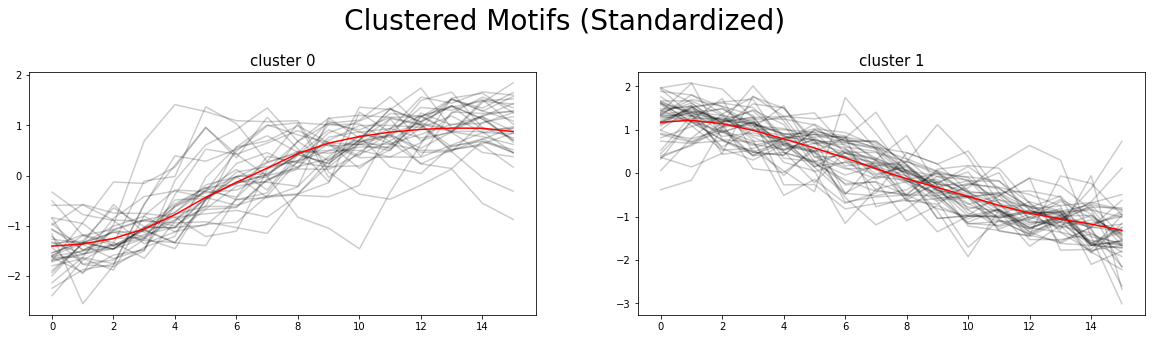

In [31]:
# display clusters
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif in motifs_tform[motif_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(motif_4hr_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)

In [32]:
print(f'cluster 1 size: {np.sum(motif_locs == 0)}')
print(f'cluster 2 size: {np.sum(motif_locs == 1)}')

cluster 1 size: 34
cluster 2 size: 45


These clustered motifs indicate that there are patterns of rising and falling prices throughout the data. We have 45 motifs indicating a downward trend and 34 motifs indicating an upward trend.

<br>
It would be interesting to see the 4 hour period before and after these patterns are discovered. Let's investigate

<br>

It would also be interesting to investigate more short term motifs, but it seems like there is a good price increase/decrease that takes place during this 4 hour window_4hr. So let's try a 2 hour window_4hr and see what happens.

In [33]:
window_2hr = 8 
matrix_profile_2hr = stumpy.stump(train_df['close'].sort_index(), m=window_2hr)

Get useful 2hr mmotifs

In [40]:
useful_motif_indexes_2hr = filter_motif_indexes(matrix_profile_2hr, thresh=5)

In [41]:
len(useful_motif_indexes_2hr)

647

Filter motifs

In [42]:
ext_window = 3
motifs, motif_idxs, ext_motifs, ext_outside = clean_motifs(useful_motif_indexes_2hr, 
                                                           matrix_profile_2hr, 
                                                           window_2hr, 
                                                           ext_window)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Plot top 25 2 hr motifs

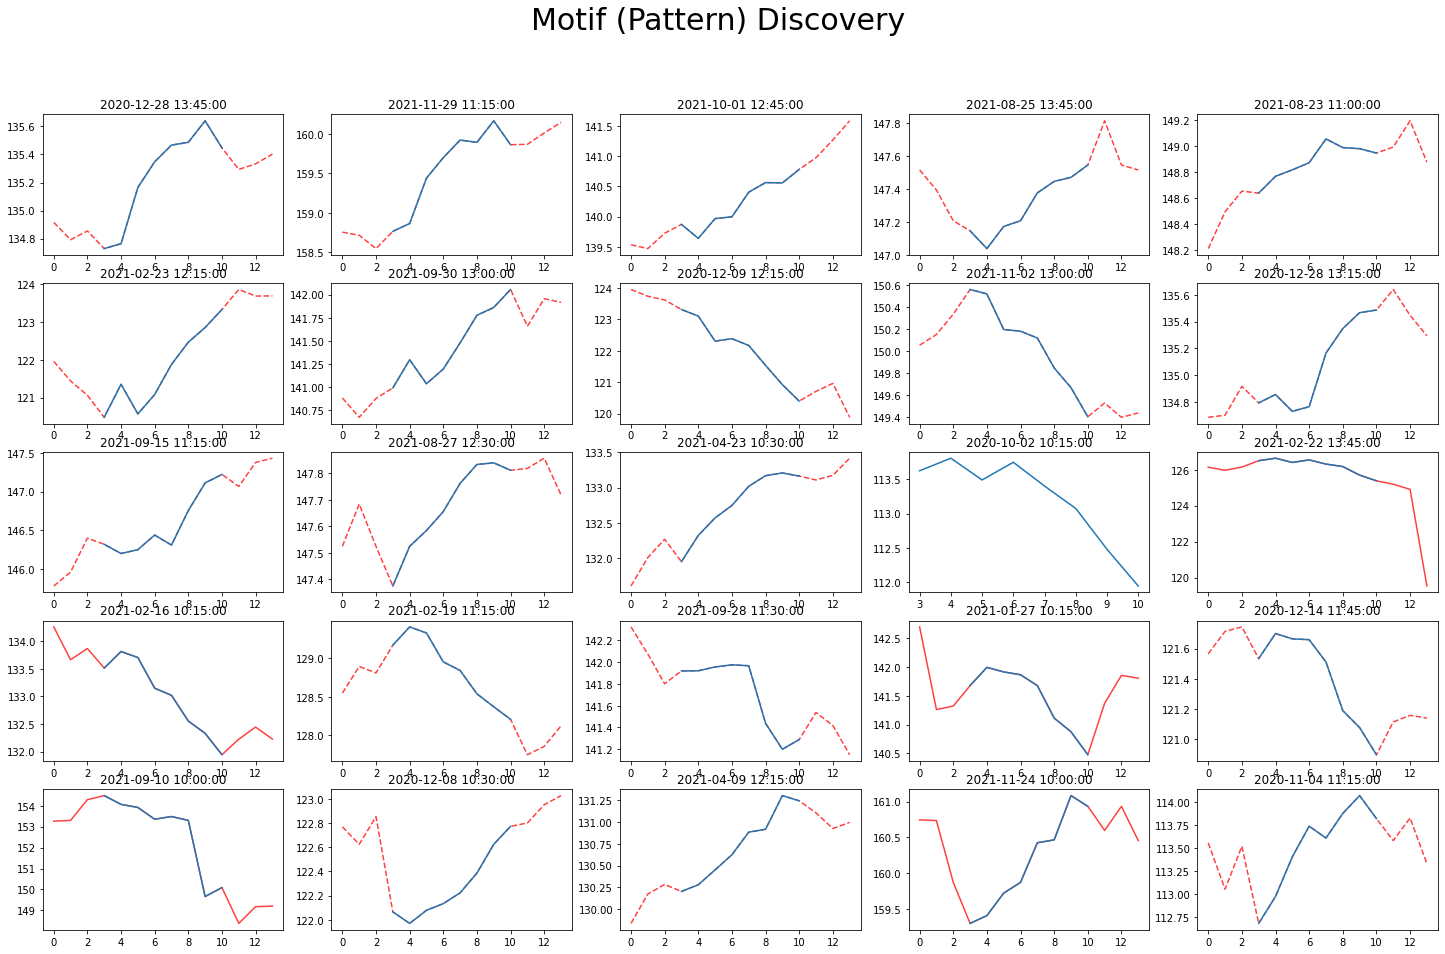

In [43]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []


fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif = motifs[i]
    m_idx = motif_idxs[i]
    ext_motif = ext_motifs[i]
    ext_out = ext_outside[i]


    # plot motif 
    if ext_out == 0:
        plt.plot(ext_motif, 'r--', alpha=0.75)
        plt.plot(np.arange(ext_window, window_2hr + ext_window), motif)
    else:
        plt.plot(ext_motif, 'r', alpha=0.75)
        plt.plot(np.arange(ext_window, window_2hr + ext_window), motif)

    
    plt.title(train_df['close'].index[m_idx])


In [44]:
# get kmeans clustering object
n_clusters = 5
motif_2hr_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",
                                    max_iter=10, random_state=42)

In [45]:
motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(motifs) \
                                                   .squeeze()

In [46]:
motif_locs = motif_2hr_kmeans.fit_predict(motifs_tform)

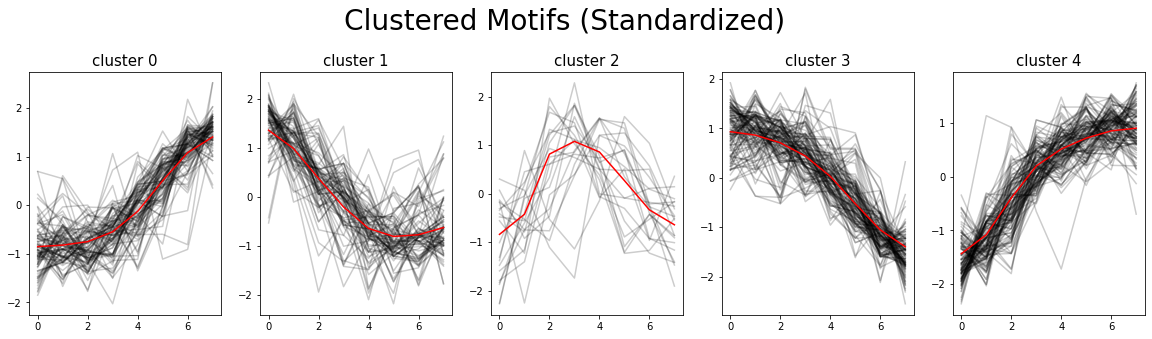

In [47]:
# display clusters
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif in motifs_tform[motif_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(motif_2hr_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)

In [48]:
print(f'cluster 1 size: {np.sum(motif_locs == 0)}')
print(f'cluster 2 size: {np.sum(motif_locs == 1)}')
print(f'cluster 3 size: {np.sum(motif_locs == 2)}')
print(f'cluster 4 size: {np.sum(motif_locs == 3)}')
print(f'cluster 5 size: {np.sum(motif_locs == 4)}')

cluster 1 size: 91
cluster 2 size: 81
cluster 3 size: 20
cluster 4 size: 119
cluster 5 size: 117


We can see that their are 200 falling clusters and 91 rising clusters, indicating that trades can still be made during the 2 hour window. We count cluster 2 as an anomaly, since it is sparse (20 values) and has a rise and fall within the 2 hour window. The behavior of this cluster, suggests that there may be adequate price action that occurs within a one hour time frame.

## Get 1hr Motifs

In [51]:
window_1hr = 4 
matrix_profile_1hr = stumpy.stump(train_df['close'].sort_index(), m=window_1hr)

In [52]:
useful_motif_indexes_1hr = filter_motif_indexes(matrix_profile_1hr, thresh=4)

In [53]:
len(useful_motif_indexes_1hr)

881

In [54]:
ext_window = 4
motifs, motif_idxs, ext_motifs, ext_outside = clean_motifs(useful_motif_indexes_1hr, 
                                                           matrix_profile_1hr, 
                                                           window_1hr, 
                                                           ext_window)

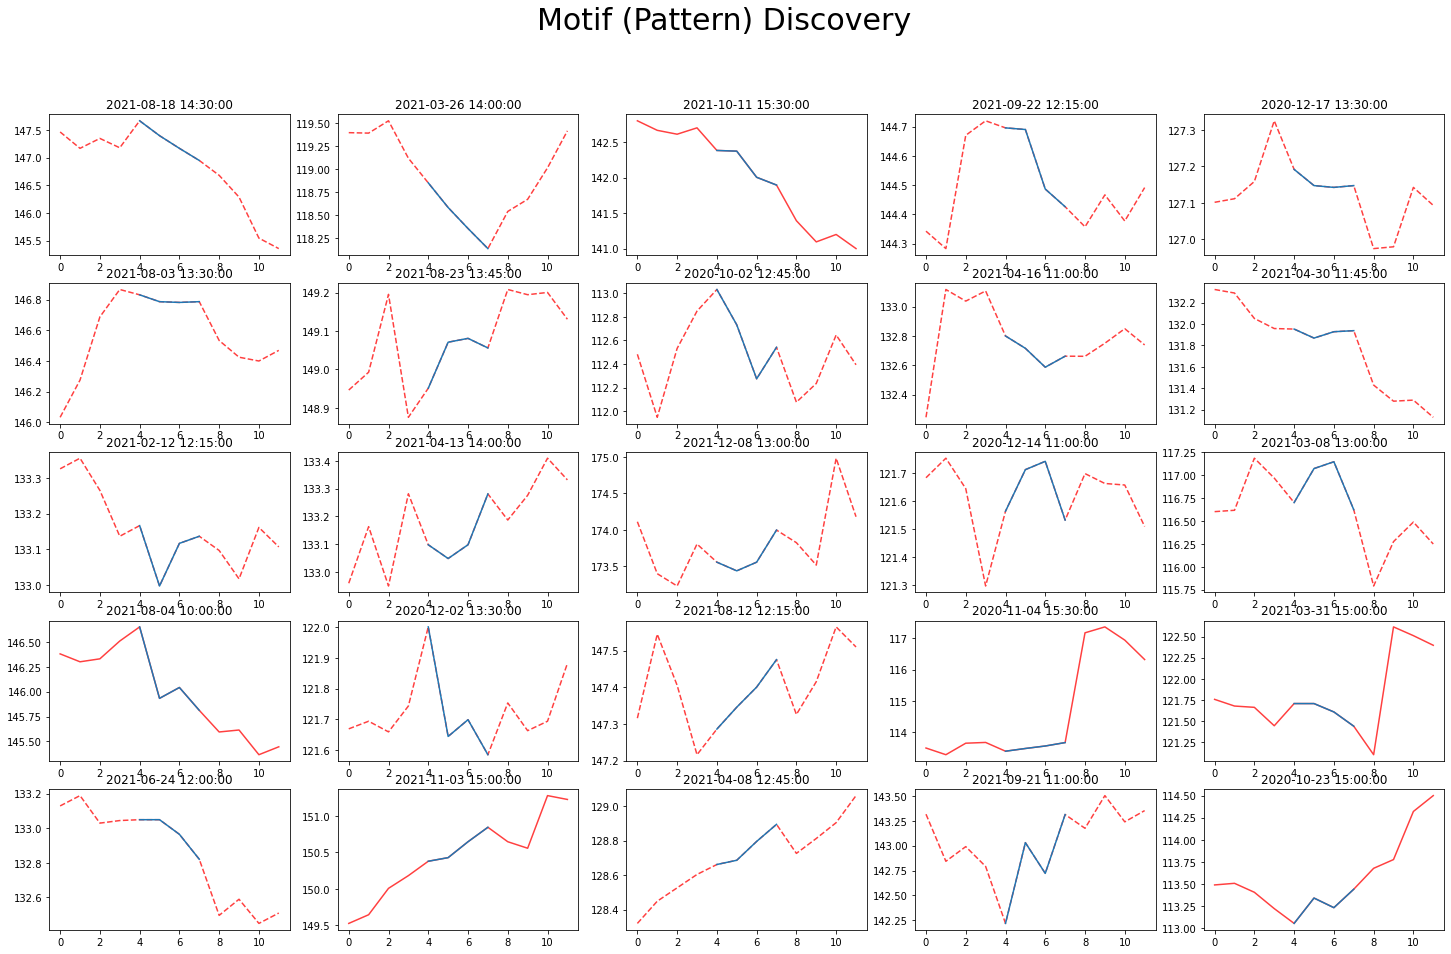

In [55]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []


fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif = motifs[i]
    m_idx = motif_idxs[i]
    ext_motif = ext_motifs[i]
    ext_out = ext_outside[i]


    # plot motif 
    if ext_out == 0:
        plt.plot(ext_motif, 'r--', alpha=0.75)
        plt.plot(np.arange(ext_window, window_1hr + ext_window), motif)
    else:
        plt.plot(ext_motif, 'r', alpha=0.75)
        plt.plot(np.arange(ext_window, window_1hr + ext_window), motif)

    
    plt.title(train_df['close'].index[m_idx])

In [56]:
# get kmeans clustering object
n_clusters = 8
motif_1hr_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",
                                    max_iter=10, random_state=42)

In [57]:
motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(motifs) \
                                                   .squeeze()

In [59]:
motif_locs = motif_1hr_kmeans.fit_predict(motifs_tform)

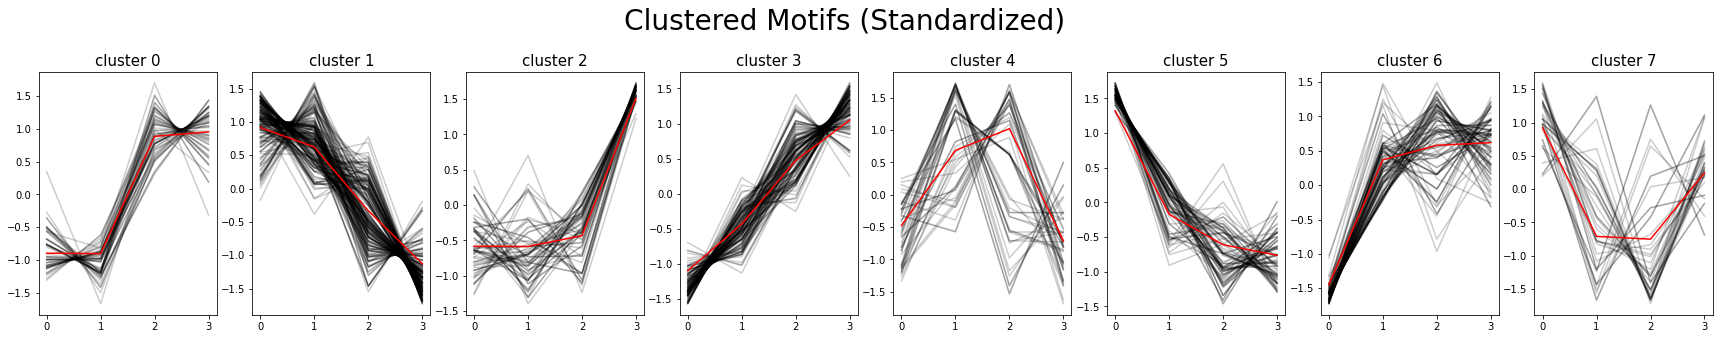

In [61]:
# display clusters
fig = plt.figure(figsize=(30, 5))
fig.suptitle('Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif in motifs_tform[motif_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(motif_1hr_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)

### Display Extended clusters

In [65]:
ext_motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(ext_motifs) \
                                                   .squeeze()

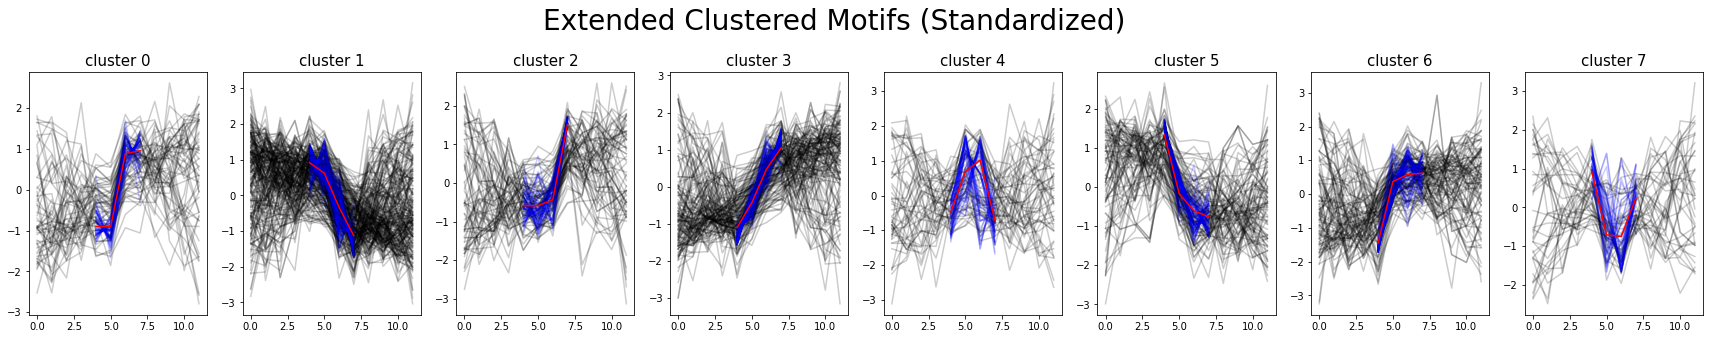

In [71]:
# display clusters
fig = plt.figure(figsize=(30, 5))
fig.suptitle('Extended Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif, ext_motif in zip(motifs_tform[motif_locs == i], ext_motifs_tform[motif_locs == i]):
        plt.plot(ext_motif.ravel(), 'k-', alpha=.2)
        plt.plot(np.arange(ext_window, window_1hr + ext_window),
                 motif.ravel(), 'b-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(np.arange(ext_window, window_1hr + ext_window), 
             motif_1hr_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)